=== MODELADO DE ENERGÍA SOLAR FOTOVOLTAICA ===

Por favor, ingrese la ubicación:
Latitud (grados decimales, ej. 40.4168 para Madrid): 40.4168
Longitud (grados decimales, ej. -3.7038 para Madrid): -3.7038

Ingrese la fecha para el análisis:
Año (ej. 2023): 2023
Mes (1-12): 6
Día (1-31): 21

Ingrese la configuración del panel solar:
Ángulo de inclinación (grados, 0-90): 90
Orientación (azimut en grados, 0=Norte, 180=Sur): 180

Ingrese las características del panel:
Área del panel (m²): 2
Eficiencia del panel (0-1, ej. 0.18 para 18%): 0.18


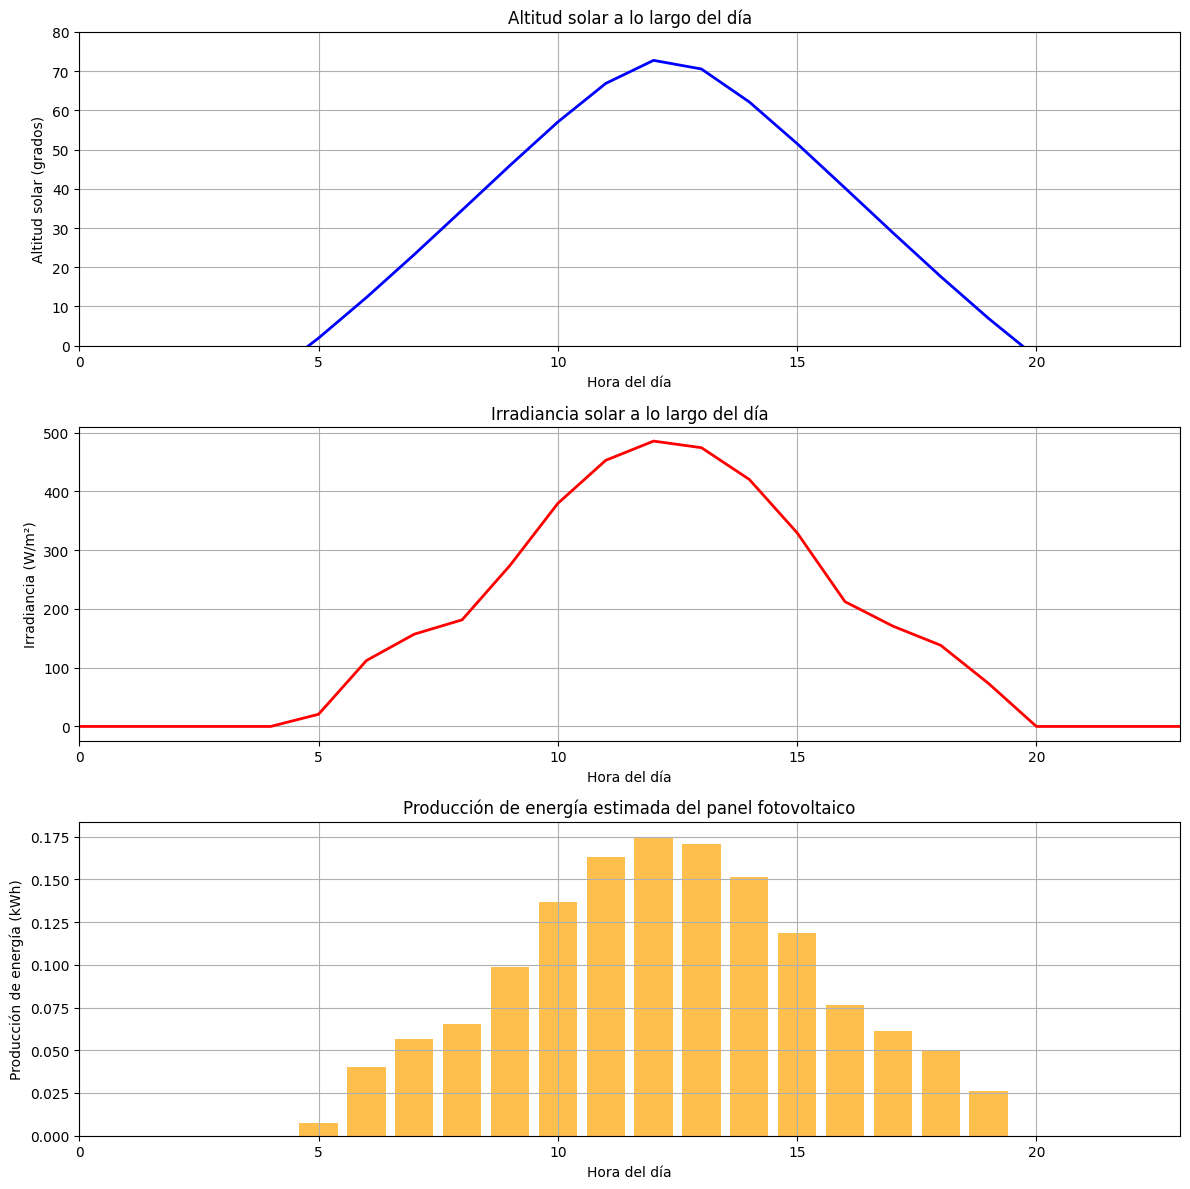


=== RESULTADOS DEL ANÁLISIS ===
Ubicación: Lat 40.4168°, Lon -3.7038°
Fecha: 2023-06-21
Configuración del panel: Inclinación 90.0°, Azimut 180.0°
Características del panel: Área 2.0m², Eficiencia 18.0%

Producción total estimada para el día: 1.40 kWh
Irradiancia máxima: 485.72 W/m²
Hora de máxima producción: 12:00

Resultados detallados guardados en: solar_results_20230621.csv
Gráficos guardados en: solar_analysis_20230621.png


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, time
import math
import pandas as pd
import argparse
from typing import Tuple, List, Optional

class SolarEnergyModel:
    def __init__(self):
        self.solar_constant = 1361  # W/m²
        self.albedo = 0.25  # Reflectividad del suelo

    def calculate_solar_position(self,
                               latitude: float,
                               longitude: float,
                               date_time: datetime) -> Tuple[float, float]:
        """
        Calcula la altitud y azimut solar para una ubicación y momento específicos.

        Args:
            latitude: Latitud en grados decimales
            longitude: Longitud en grados decimales
            date_time: Fecha y hora para el cálculo

        Returns:
            Tuple con altitud solar (grados) y azimut solar (grados)
        """
        # Convertir a radianes
        lat_rad = math.radians(latitude)

        # Día del año (1-365)
        day_of_year = date_time.timetuple().tm_yday

        # Fracción del año en radianes
        year_angle = 2 * math.pi * (day_of_year - 1) / 365.25

        # Declinación solar (aproximación de Cooper)
        declination = 23.45 * math.sin(2 * math.pi * (284 + day_of_year) / 365)
        declination_rad = math.radians(declination)

        # Hora solar
        time_offset = longitude / 15  # Ajuste por longitud
        solar_time = date_time.hour + date_time.minute/60 + time_offset

        # Ángulo horario
        hour_angle = 15 * (solar_time - 12)  # Grados
        hour_angle_rad = math.radians(hour_angle)

        # Altitud solar
        sin_altitude = (math.sin(lat_rad) * math.sin(declination_rad) +
                       math.cos(lat_rad) * math.cos(declination_rad) * math.cos(hour_angle_rad))
        altitude = math.degrees(math.asin(sin_altitude))

        # Azimut solar
        cos_azimuth = ((math.sin(declination_rad) * math.cos(lat_rad) -
                       math.cos(declination_rad) * math.sin(lat_rad) * math.cos(hour_angle_rad)) /
                       math.cos(math.radians(altitude)))
        azimuth = math.degrees(math.acos(cos_azimuth))

        # Ajustar azimut según la mañana/tarde
        if hour_angle > 0:
            azimuth = 360 - azimuth

        return altitude, azimuth

    def calculate_irradiance(self,
                           altitude: float,
                           panel_tilt: float,
                           panel_azimuth: float,
                           solar_azimuth: float) -> float:
        """
        Calcula la irradiación solar en un panel inclinado.

        Args:
            altitude: Altitud solar en grados
            panel_tilt: Inclinación del panel en grados
            panel_azimuth: Orientación del panel en grados
            solar_azimuth: Azimut solar en grados

        Returns:
            Irradiancia total en W/m²
        """
        # Convertir a radianes
        altitude_rad = math.radians(altitude)
        panel_tilt_rad = math.radians(panel_tilt)
        azimuth_diff_rad = math.radians(abs(panel_azimuth - solar_azimuth))

        # Componente directa (Beam)
        cos_incidence = (math.sin(altitude_rad) * math.cos(panel_tilt_rad) +
                        math.cos(altitude_rad) * math.sin(panel_tilt_rad) * math.cos(azimuth_diff_rad))
        cos_incidence = max(0, cos_incidence)  # No valores negativos

        # Irradiancia directa normal (simplificada)
        air_mass = 1 / (math.sin(altitude_rad) + 0.50572 * (6.07995 + altitude) ** -1.6364)
        dni = self.solar_constant * 0.7 ** (air_mass ** 0.678)  # Modelo Hottel

        beam_irradiance = dni * cos_incidence

        # Componente difusa (modelo isotrópico)
        diffuse_irradiance = 0.1 * dni  # Simplificación

        # Componente reflejada
        reflected_irradiance = 0.5 * self.albedo * dni * (1 - math.cos(panel_tilt_rad))

        # Irradiancia total
        total_irradiance = beam_irradiance + diffuse_irradiance + reflected_irradiance

        return total_irradiance

    def calculate_energy_production(self,
                                  irradiance: float,
                                  panel_area: float,
                                  panel_efficiency: float) -> float:
        """
        Calcula la producción de energía eléctrica.

        Args:
            irradiance: Irradiancia en W/m²
            panel_area: Área del panel en m²
            panel_efficiency: Eficiencia del panel (0-1)

        Returns:
            Producción de energía en Wh
        """
        return irradiance * panel_area * panel_efficiency / 1000  # Convertir a kWh

def get_user_input():
    """
    Solicita al usuario los parámetros de entrada necesarios.
    """
    print("=== MODELADO DE ENERGÍA SOLAR FOTOVOLTAICA ===\n")

    # Solicitar ubicación
    print("Por favor, ingrese la ubicación:")
    latitude = float(input("Latitud (grados decimales, ej. 40.4168 para Madrid): "))
    longitude = float(input("Longitud (grados decimales, ej. -3.7038 para Madrid): "))

    # Solicitar fecha
    print("\nIngrese la fecha para el análisis:")
    year = int(input("Año (ej. 2023): "))
    month = int(input("Mes (1-12): "))
    day = int(input("Día (1-31): "))

    # Solicitar configuración del panel
    print("\nIngrese la configuración del panel solar:")
    panel_tilt = float(input("Ángulo de inclinación (grados, 0-90): "))
    panel_azimuth = float(input("Orientación (azimut en grados, 0=Norte, 180=Sur): "))

    # Solicitar características del panel
    print("\nIngrese las características del panel:")
    panel_area = float(input("Área del panel (m²): "))
    panel_efficiency = float(input("Eficiencia del panel (0-1, ej. 0.18 para 18%): "))

    # Crear objeto datetime
    date = datetime(year, month, day)

    return {
        'latitude': latitude,
        'longitude': longitude,
        'date': date,
        'panel_tilt': panel_tilt,
        'panel_azimuth': panel_azimuth,
        'panel_area': panel_area,
        'panel_efficiency': panel_efficiency
    }

def main():
    # Obtener parámetros del usuario
    user_input = get_user_input()

    # Configurar modelo
    model = SolarEnergyModel()

    # Extraer parámetros
    latitude = user_input['latitude']
    longitude = user_input['longitude']
    date = user_input['date']
    panel_tilt = user_input['panel_tilt']
    panel_azimuth = user_input['panel_azimuth']
    panel_area = user_input['panel_area']
    panel_efficiency = user_input['panel_efficiency']

    # Generar datos para todo el día
    hours = np.arange(0, 24, 1)
    altitudes = []
    azimuths = []
    irradiances = []
    energy_productions = []

    for hour in hours:
        current_time = datetime(date.year, date.month, date.day, hour)
        altitude, azimuth = model.calculate_solar_position(latitude, longitude, current_time)

        if altitude > 0:  # Solo durante el día
            irradiance = model.calculate_irradiance(altitude, panel_tilt, panel_azimuth, azimuth)
            energy = model.calculate_energy_production(irradiance, panel_area, panel_efficiency)
        else:
            irradiance = 0
            energy = 0

        altitudes.append(altitude)
        azimuths.append(azimuth)
        irradiances.append(irradiance)
        energy_productions.append(energy)

    # Visualización
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))

    # Gráfico de altitud solar
    ax1.plot(hours, altitudes, 'b-', linewidth=2)
    ax1.set_xlabel('Hora del día')
    ax1.set_ylabel('Altitud solar (grados)')
    ax1.set_title('Altitud solar a lo largo del día')
    ax1.grid(True)
    ax1.set_xlim(0, 23)
    ax1.set_ylim(0, max(altitudes) * 1.1 if max(altitudes) > 0 else 90)

    # Gráfico de irradiancia
    ax2.plot(hours, irradiances, 'r-', linewidth=2)
    ax2.set_xlabel('Hora del día')
    ax2.set_ylabel('Irradiancia (W/m²)')
    ax2.set_title('Irradiancia solar a lo largo del día')
    ax2.grid(True)
    ax2.set_xlim(0, 23)

    # Gráfico de producción de energía
    ax3.bar(hours, energy_productions, alpha=0.7, color='orange')
    ax3.set_xlabel('Hora del día')
    ax3.set_ylabel('Producción de energía (kWh)')
    ax3.set_title('Producción de energía estimada del panel fotovoltaico')
    ax3.grid(True)
    ax3.set_xlim(0, 23)

    plt.tight_layout()

    # Guardar gráficos
    filename = f"solar_analysis_{date.strftime('%Y%m%d')}.png"
    plt.savefig(filename)
    plt.show()

    # Resumen diario
    total_energy = sum(energy_productions)
    max_irradiance = max(irradiances)
    max_energy_hour = hours[np.argmax(energy_productions)]

    print("\n=== RESULTADOS DEL ANÁLISIS ===")
    print(f"Ubicación: Lat {latitude}°, Lon {longitude}°")
    print(f"Fecha: {date.strftime('%Y-%m-%d')}")
    print(f"Configuración del panel: Inclinación {panel_tilt}°, Azimut {panel_azimuth}°")
    print(f"Características del panel: Área {panel_area}m², Eficiencia {panel_efficiency*100}%")
    print(f"\nProducción total estimada para el día: {total_energy:.2f} kWh")
    print(f"Irradiancia máxima: {max_irradiance:.2f} W/m²")
    print(f"Hora de máxima producción: {int(max_energy_hour):02d}:00")

    # Crear tabla de resultados
    results_df = pd.DataFrame({
        'Hora': hours,
        'Altitud_solar': altitudes,
        'Azimut_solar': azimuths,
        'Irradiancia_W/m2': irradiances,
        'Energia_kWh': energy_productions
    })

    # Guardar resultados en CSV
    csv_filename = f"solar_results_{date.strftime('%Y%m%d')}.csv"
    results_df.to_csv(csv_filename, index=False)

    print(f"\nResultados detallados guardados en: {csv_filename}")
    print(f"Gráficos guardados en: {filename}")

if __name__ == "__main__":
    main()
